# Imports and Installs

In [1]:
#%pip install git+https://github.com/TattaBio/DGEB.git

In [2]:
# Standard library imports
import os
import re
import gzip
import warnings
import pickle

# Third-party imports - Data & Numerical
import numpy as np
import pandas as pd

# Set global random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Third-party imports - Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Third-party imports - Progress bars
from tqdm.auto import tqdm

# Third-party imports - Bioinformatics
from Bio import SeqIO, motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Third-party imports - Machine Learning (scikit-learn)
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_predict,
    train_test_split
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Third-party imports - XGBoost
from xgboost import XGBClassifier

# Third-party imports - SHAP
import shap

# Third-party imports - Transformers & DGEB (for ESM work later)
from transformers import AutoTokenizer, AutoModel
from dgeb.tasks import EcoliOperon, PairClassificationEvaluator
from datasets import load_dataset

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [3]:
pairs_df = pd.read_csv("data/ecoli_pairs.csv")
pairs_df.columns

Index(['Entry_A', 'Sequence_A', 'refseq_A', 'locus_tag_A', 'start_A', 'end_A',
       'strand_A', 'gene_seq_A', 'gc_content_A', 'Entry_B', 'Sequence_B',
       'refseq_B', 'locus_tag_B', 'start_B', 'end_B', 'strand_B', 'gene_seq_B',
       'gc_content_B', 'gc_content_diff', 'Label', 'COG_category_A',
       'COG_category_B', 'COG_match', 'COG_similar', 'strand_concordant',
       'intergenic_distance', 'genes_overlap', 'overlap_length',
       'orientation_++', 'orientation_--', 'orientation_+-', 'orientation_-+',
       'intergenic_seq', 'trinuc_AAA', 'trinuc_AAC', 'trinuc_AAG',
       'trinuc_AAT', 'trinuc_ACA', 'trinuc_ACC', 'trinuc_ACG', 'trinuc_ACT',
       'trinuc_AGA', 'trinuc_AGC', 'trinuc_AGG', 'trinuc_AGT', 'trinuc_ATA',
       'trinuc_ATC', 'trinuc_ATG', 'trinuc_ATT', 'trinuc_CAA', 'trinuc_CAC',
       'trinuc_CAG', 'trinuc_CAT', 'trinuc_CCA', 'trinuc_CCC', 'trinuc_CCG',
       'trinuc_CCT', 'trinuc_CGA', 'trinuc_CGC', 'trinuc_CGG', 'trinuc_CGT',
       'trinuc_CTA', 'trinuc

### Defining features and target

In [4]:
# Define which columns are features vs. target
# Trinucleotide features serve as promoter region signatures
# (see Janga et al. 2006: https://pmc.ncbi.nlm.nih.gov/articles/PMC1557821/)
trinuc_cols = [col for col in pairs_df.columns if col.startswith('trinuc_')]

feature_cols = [
    # Sequence features
    "gc_content_A", "gc_content_B", "gc_content_diff",
    
    # Genomic architecture
    "intergenic_distance", "genes_overlap", "overlap_length",
    
    # Orientation (already one-hot encoded)
    "orientation_++", "orientation_--", "orientation_+-", "orientation_-+",
    
    # Binary flags
    "strand_concordant",

    #COG annotations
    "COG_match", "COG_similar"
    
   
] + trinuc_cols  # Promoter features (trinucleotide counts in intergenic region)

target_col = "Label"

# Separate feature groups for preprocessing
numeric_features = [
    "gc_content_A", "gc_content_B", "gc_content_diff",
    "intergenic_distance", "overlap_length",
] + trinuc_cols  # trinuc features are counts (numeric)

binary_features = [
    "orientation_++", "orientation_--", "orientation_+-", "orientation_-+",
    "strand_concordant", "genes_overlap", "COG_match", "COG_similar"
]

print(f"Total features: {len(feature_cols)}")
print(f"  - Numeric: {len(numeric_features)}")
print(f"  - Binary: {len(binary_features)}")

Total features: 77
  - Numeric: 69
  - Binary: 8


### Train/validation split

In [5]:
# Extract features and target
X = pairs_df[feature_cols].copy()
y = pairs_df[target_col].astype(int)

print(f"Dataset shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Class balance: {y.value_counts(normalize=True)}")

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

print(f"Split sizes:")
print(f"  Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")

Dataset shape: (4297, 77)
Class distribution:
Label
0    2550
1    1747
Name: count, dtype: int64
Class balance: Label
0    0.593437
1    0.406563
Name: proportion, dtype: float64
Split sizes:
  Train: 3652 samples (85.0%)
  Val:   645 samples (15.0%)


In [6]:
# Preprocessors: scale only numeric features, pass binary features through unchanged
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features)
    ]
)

preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('bin', 'passthrough', binary_features)
    ]
)

print("✅ Preprocessors defined")
print(f"   - Scaling {len(numeric_features)} numeric features")
print(f"   - Passing through {len(binary_features)} binary features")


✅ Preprocessors defined
   - Scaling 69 numeric features
   - Passing through 8 binary features


# Training

## Gridsearch - hyperparameter tuning

In [7]:
print("🔧 Hyperparameter Tuning - All Models\n")

# Define models to tune with their grids
# NOTE: Use scaled preprocessor for distance-based, unscaled for tree-based
models_to_tune = {
    'Logistic Regression': {
        'estimator': Pipeline([
            ('preprocessor', preprocessor_scaled),  # needs scaling
            ('classifier', LogisticRegression(
                penalty='elasticnet',
                solver='saga',
                max_iter=5000,
                random_state=42,
                n_jobs=-1
            ))
        ]),
        'param_grid': {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__l1_ratio': [0.05, 0.1, 0.5, 0.9]
        }
    },
    'Random Forest': {
        'estimator': Pipeline([
            ('preprocessor', preprocessor_unscaled),  # tree-based, no scaling
            ('classifier', RandomForestClassifier(
                random_state=42,
                n_jobs=-1
            ))
        ]),
        'param_grid': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 15, 20, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2']
        }
    },
    'XGBoost': {
        'estimator': Pipeline([
            ('preprocessor', preprocessor_unscaled),  # tree-based, no scaling
            ('classifier', XGBClassifier(
                random_state=42,
                n_jobs=-1,
                eval_metric='logloss',
            ))
        ]),
        'param_grid': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 6, 9, 12],
            'classifier__learning_rate': [0.01, 0.05, 0.1, 0.3],
            'classifier__subsample': [0.6,0.8, 1.0],
            'classifier__colsample_bytree': [0.6,0.8, 1.0],
        }
    },
    'SVM': {
        'estimator': Pipeline([
            ('preprocessor', preprocessor_scaled),  # needs scaling
            ('classifier', SVC(
                probability=True,
                random_state=42
            ))
        ]),
        'param_grid': {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__kernel': ['rbf', 'linear'],
            'classifier__gamma': ['scale', 'auto', 0.01, 0.1]  # only used for rbf
        }
    },
    'MLP': {
        'estimator': Pipeline([
            ('preprocessor', preprocessor_scaled),  # needs scaling
            ('classifier', MLPClassifier(
                max_iter=1000,
                early_stopping=True,
                random_state=42
            ))
        ]),
        'param_grid': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (200, 100)],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__alpha': [0.0001, 0.001, 0.01],
            'classifier__learning_rate': ['constant', 'adaptive']
        }
    },
    'Naive Bayes': {
        'estimator': Pipeline([
            ('preprocessor', preprocessor_scaled),  # needs scaling
            ('classifier', GaussianNB())
        ]),
        'param_grid': {}  # No hyperparameters to tune - just use defaults
    }
}

# Calculate total combinations for each model
print("📊 Grid Search Sizes:")
for model_name, config in models_to_tune.items():
    n_combinations = int(np.prod([len(v) for v in config['param_grid'].values()])) or 1
    print(f"   {model_name:25s}: {n_combinations:4d} combinations")

print(f"\nNote: Using 5-fold CV, so each combination trains 5 models\n")
print("⏱️  Estimated time: 30-60 minutes total\n")
print("=" * 70)

# Run grid search for each model
best_results = {}
best_pipelines = {}

for model_name in tqdm(models_to_tune.keys(), desc="Overall tuning progress"):
    tqdm.write(f"\n🔧 Tuning {model_name}...")
    
    model_config = models_to_tune[model_name]
    
    grid = GridSearchCV(
        estimator=model_config['estimator'],
        param_grid=model_config['param_grid'],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search on RAW data (preprocessing happens inside pipeline)
    grid.fit(X_train, y_train)
    
    # Store results
    best_results[model_name] = {
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'cv_results': grid.cv_results_
    }
    
    # Store best pipeline (fitted during CV - will clone fresh copies later)
    best_pipelines[model_name] = grid.best_estimator_
    
    # Extract classifier params for display
    classifier_params = {
        k.replace('classifier__', ''): v 
        for k, v in grid.best_params_.items()
    }
    
    tqdm.write(f"   ✓ Best CV F1: {grid.best_score_:.3f}")
    tqdm.write(f"   ✓ Best params: {classifier_params}")

print("\n" + "=" * 70)
print("  HYPERPARAMETER TUNING COMPLETE")
print("=" * 70)

# Print detailed CV results for each model
print("\n" + "=" * 100)
print("📊 DETAILED CROSS-VALIDATION RESULTS - ALL PARAMETER COMBINATIONS")
print("=" * 100)

for model_name, results in best_results.items():
    print(f"\n{'='*100}")
    print(f"🔍 {model_name}")
    print(f"{'='*100}")
    
    # Extract CV results
    cv_results = results['cv_results']
    
    # Create a DataFrame with all CV results
    cv_df = pd.DataFrame({
        'params': cv_results['params'],
        'mean_cv_score': cv_results['mean_test_score'],
        'std_cv_score': cv_results['std_test_score'],
        'rank': cv_results['rank_test_score']
    })
    
    # Clean up parameter names (remove 'classifier__' prefix)
    cv_df['params'] = cv_df['params'].apply(
        lambda x: {k.replace('classifier__', ''): v for k, v in x.items()}
    )
    
    # Sort by rank
    cv_df = cv_df.sort_values('rank').reset_index(drop=True)
    
    # Display top 10 configurations
    print(f"\nTop 10 Parameter Combinations (out of {len(cv_df)} total):\n")
    
    for idx, row in cv_df.head(10).iterrows():
        print(f"Rank {row['rank']:3.0f} | CV F1: {row['mean_cv_score']:.4f} (±{row['std_cv_score']:.4f}) | Params: {row['params']}")
    
    # Also show full table in pandas
    print(f"\n📋 Complete Results Table (showing top 20):\n")
    display_df = cv_df.head(20).copy()
    display_df['mean_cv_score'] = display_df['mean_cv_score'].apply(lambda x: f"{x:.4f}")
    display_df['std_cv_score'] = display_df['std_cv_score'].apply(lambda x: f"±{x:.4f}")
    display_df['rank'] = display_df['rank'].astype(int)
    display(display_df)
    
    # Show summary statistics
    print(f"\n📈 Summary Statistics:")
    print(f"   • Best CV Score:  {cv_df['mean_cv_score'].max():.4f}")
    print(f"   • Worst CV Score: {cv_df['mean_cv_score'].min():.4f}")
    print(f"   • Mean CV Score:  {cv_df['mean_cv_score'].mean():.4f}")
    print(f"   • Median CV Score: {cv_df['mean_cv_score'].median():.4f}")
    print(f"   • Std Dev:        {cv_df['mean_cv_score'].std():.4f}")
    print(f"   • Total Combinations Tested: {len(cv_df)}")

print("\n" + "=" * 100)
print("📊 BEST PARAMETERS SUMMARY")
print("=" * 100)

# Print detailed summary
for model_name, results in best_results.items():
    print(f"\n📊 {model_name}:")
    print(f"   Best CV F1 Score: {results['best_score']:.4f}")
    print(f"   Best Parameters:")
    for param, value in results['best_params'].items():
        # Remove 'classifier__' prefix for readability
        clean_param = param.replace('classifier__', '')
        print(f"      • {clean_param}: {value}")

print(f"\n✅ Best pipelines stored: {list(best_pipelines.keys())}")
print("✅ Next: Clone fresh copies of these pipelines to avoid data leakage before final training.")

🔧 Hyperparameter Tuning - All Models

📊 Grid Search Sizes:
   Logistic Regression      :   16 combinations
   Random Forest            :  216 combinations
   XGBoost                  :  432 combinations
   SVM                      :   32 combinations
   MLP                      :   60 combinations
   Naive Bayes              :    1 combinations

Note: Using 5-fold CV, so each combination trains 5 models

⏱️  Estimated time: 30-60 minutes total



Overall tuning progress:   0%|          | 0/6 [00:00<?, ?it/s]


🔧 Tuning Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
   ✓ Best CV F1: 0.867
   ✓ Best params: {'C': 0.1, 'l1_ratio': 0.05}

🔧 Tuning Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
   ✓ Best CV F1: 0.867
   ✓ Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

🔧 Tuning XGBoost...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
   ✓ Best CV F1: 0.875
   ✓ Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}

🔧 Tuning SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
   ✓ Best CV F1: 0.871
   ✓ Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

🔧 Tuning MLP...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
   ✓ Best CV F1: 0.870
   ✓ Best params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learnin

,params,mean_cv_score,std_cv_score,rank
0,"{'C': 0.1, 'l1_ratio': 0.05}",0.8667,±0.0118,1
1,"{'C': 0.1, 'l1_ratio': 0.1}",0.8666,±0.0120,2
2,"{'C': 0.1, 'l1_ratio': 0.5}",0.8661,±0.0126,3
3,"{'C': 0.1, 'l1_ratio': 0.9}",0.8648,±0.0119,4
4,"{'C': 10, 'l1_ratio': 0.05}",0.8627,±0.0140,5
5,"{'C': 10, 'l1_ratio': 0.1}",0.8627,±0.0140,5
6,"{'C': 100, 'l1_ratio': 0.05}",0.8626,±0.0138,7
7,"{'C': 100, 'l1_ratio': 0.1}",0.8626,±0.0138,7
8,"{'C': 100, 'l1_ratio': 0.5}",0.8626,±0.0138,7
9,"{'C': 100, 'l1_ratio': 0.9}",0.8626,±0.0138,7



📈 Summary Statistics:
   • Best CV Score:  0.8667
   • Worst CV Score: 0.8616
   • Mean CV Score:  0.8633
   • Median CV Score: 0.8626
   • Std Dev:        0.0017
   • Total Combinations Tested: 16

🔍 Random Forest

Top 10 Parameter Combinations (out of 216 total):

Rank   1 | CV F1: 0.8672 (±0.0079) | Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Rank   2 | CV F1: 0.8671 (±0.0062) | Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Rank   3 | CV F1: 0.8665 (±0.0055) | Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Rank   4 | CV F1: 0.8665 (±0.0065) | Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Rank   5 | CV F1: 0.8662 (±0.0084) | Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_lea

,params,mean_cv_score,std_cv_score,rank
0,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.8672,±0.0079,1
1,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.8671,±0.0062,2
2,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.8665,±0.0055,3
3,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.8665,±0.0065,4
4,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.8662,±0.0084,5
5,"{'max_depth': 15, 'max_features': 'sqrt', 'min...",0.8661,±0.0067,6
6,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.8660,±0.0078,7
7,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.8660,±0.0061,8
8,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.8660,±0.0081,9
9,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.8659,±0.0100,10



📈 Summary Statistics:
   • Best CV Score:  0.8672
   • Worst CV Score: 0.8581
   • Mean CV Score:  0.8627
   • Median CV Score: 0.8629
   • Std Dev:        0.0019
   • Total Combinations Tested: 216

🔍 XGBoost

Top 10 Parameter Combinations (out of 432 total):

Rank   1 | CV F1: 0.8750 (±0.0077) | Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Rank   2 | CV F1: 0.8748 (±0.0081) | Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Rank   3 | CV F1: 0.8739 (±0.0067) | Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Rank   4 | CV F1: 0.8737 (±0.0073) | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Rank   5 | CV F1: 0.8735 (±0.0031) | Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0

,params,mean_cv_score,std_cv_score,rank
0,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.8750,±0.0077,1
1,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.8748,±0.0081,2
2,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.8739,±0.0067,3
3,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.8737,±0.0073,4
4,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.8735,±0.0031,5
5,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.8729,±0.0059,6
6,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",0.8728,±0.0080,7
7,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.8727,±0.0071,8
8,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",0.8726,±0.0068,9
9,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.8726,±0.0070,10



📈 Summary Statistics:
   • Best CV Score:  0.8750
   • Worst CV Score: 0.8468
   • Mean CV Score:  0.8630
   • Median CV Score: 0.8639
   • Std Dev:        0.0058
   • Total Combinations Tested: 432

🔍 SVM

Top 10 Parameter Combinations (out of 32 total):

Rank   1 | CV F1: 0.8705 (±0.0102) | Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Rank   2 | CV F1: 0.8703 (±0.0124) | Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Rank   3 | CV F1: 0.8696 (±0.0110) | Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Rank   4 | CV F1: 0.8690 (±0.0098) | Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Rank   5 | CV F1: 0.8680 (±0.0120) | Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Rank   6 | CV F1: 0.8675 (±0.0129) | Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Rank   7 | CV F1: 0.8667 (±0.0138) | Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Rank   8 | CV F1: 0.8664 (±0.0173) | Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Rank   9 | CV F1: 0.8643 (±0.0123) | Param

,params,mean_cv_score,std_cv_score,rank
0,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.8705,±0.0102,1
1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.8703,±0.0124,2
2,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.8696,±0.0110,3
3,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.8690,±0.0098,4
4,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.8680,±0.0120,5
5,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.8675,±0.0129,6
6,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.8667,±0.0138,7
7,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.8664,±0.0173,8
8,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.8643,±0.0123,9
9,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.8643,±0.0177,10



📈 Summary Statistics:
   • Best CV Score:  0.8705
   • Worst CV Score: 0.8509
   • Mean CV Score:  0.8638
   • Median CV Score: 0.8640
   • Std Dev:        0.0039
   • Total Combinations Tested: 32

🔍 MLP

Top 10 Parameter Combinations (out of 60 total):

Rank   1 | CV F1: 0.8696 (±0.0145) | Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant'}
Rank   1 | CV F1: 0.8696 (±0.0145) | Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive'}
Rank   3 | CV F1: 0.8694 (±0.0125) | Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive'}
Rank   3 | CV F1: 0.8694 (±0.0125) | Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'constant'}
Rank   5 | CV F1: 0.8684 (±0.0083) | Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive'}
Rank  

,params,mean_cv_score,std_cv_score,rank
0,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.8696,±0.0145,1
1,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.8696,±0.0145,1
2,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.8694,±0.0125,3
3,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.8694,±0.0125,3
4,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.8684,±0.0083,5
5,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.8684,±0.0083,5
6,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.8683,±0.0095,7
7,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.8683,±0.0095,7
8,"{'activation': 'tanh', 'alpha': 0.001, 'hidden...",0.8678,±0.0163,9
9,"{'activation': 'tanh', 'alpha': 0.001, 'hidden...",0.8678,±0.0163,9



📈 Summary Statistics:
   • Best CV Score:  0.8696
   • Worst CV Score: 0.8617
   • Mean CV Score:  0.8659
   • Median CV Score: 0.8667
   • Std Dev:        0.0021
   • Total Combinations Tested: 60

🔍 Naive Bayes

Top 10 Parameter Combinations (out of 1 total):

Rank   1 | CV F1: 0.7768 (±0.0175) | Params: {}

📋 Complete Results Table (showing top 20):



,params,mean_cv_score,std_cv_score,rank
0,{},0.7768,±0.0175,1



📈 Summary Statistics:
   • Best CV Score:  0.7768
   • Worst CV Score: 0.7768
   • Mean CV Score:  0.7768
   • Median CV Score: 0.7768
   • Std Dev:        nan
   • Total Combinations Tested: 1

📊 BEST PARAMETERS SUMMARY

📊 Logistic Regression:
   Best CV F1 Score: 0.8667
   Best Parameters:
      • C: 0.1
      • l1_ratio: 0.05

📊 Random Forest:
   Best CV F1 Score: 0.8672
   Best Parameters:
      • max_depth: None
      • max_features: sqrt
      • min_samples_leaf: 1
      • min_samples_split: 5
      • n_estimators: 200

📊 XGBoost:
   Best CV F1 Score: 0.8750
   Best Parameters:
      • colsample_bytree: 1.0
      • learning_rate: 0.1
      • max_depth: 3
      • n_estimators: 100
      • subsample: 0.6

📊 SVM:
   Best CV F1 Score: 0.8705
   Best Parameters:
      • C: 10
      • gamma: 0.01
      • kernel: rbf

📊 MLP:
   Best CV F1 Score: 0.8696
   Best Parameters:
      • activation: relu
      • alpha: 0.001
      • hidden_layer_sizes: (100, 100)
      • learning_rate: constan

### Model pipelines

In [8]:
# Create FRESH pipelines with optimal hyperparameters from grid search
# This avoids data leakage - best_pipelines were fitted during CV
from sklearn.base import clone

pipelines = {}

for name, tuned_pipeline in best_pipelines.items():
    # Clone creates a fresh unfitted copy with the same hyperparameters
    pipelines[name] = clone(tuned_pipeline)

print(f"✅ {len(pipelines)} fresh pipelines created with tuned hyperparameters:")
for name in pipelines:
    print(f"   - {name}")

✅ 6 fresh pipelines created with tuned hyperparameters:
   - Logistic Regression
   - Random Forest
   - XGBoost
   - SVM
   - MLP
   - Naive Bayes


### Train

In [9]:
print("🚀 Training fresh pipelines (with tuned hyperparameters) on full training set...\n")

trained_models = {}

pbar = tqdm(pipelines.items(), total=len(pipelines), desc="Training")

for name, pipeline in pbar:
    pbar.set_description(f"Training {name:25s}")
    
    # Fit fresh (unfitted) pipeline on full training data - no data leakage
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline

print(f"\n✅ All {len(trained_models)} tuned models trained on full training set!")

🚀 Training fresh pipelines (with tuned hyperparameters) on full training set...



Training:   0%|          | 0/6 [00:00<?, ?it/s]


✅ All 6 tuned models trained on full training set!


# Evaluation

In [10]:
# Evaluate on validation set
results = {}

print("📊 Evaluating models on validation set...\n")

for name in tqdm(trained_models.keys(), desc="Evaluating"):
    pipeline = trained_models[name]
    
    # Predictions
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    
    # Metrics
    results[name] = {
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred),
        'ROC-AUC': roc_auc_score(y_val, y_pred_proba),
        'Accuracy': accuracy_score(y_val, y_pred)
    }

print("\n✅ Evaluation complete!")
print("\nQuick Preview:")
for name in results:
    print(f"  {name:25s} F1: {results[name]['F1']:.3f}")

📊 Evaluating models on validation set...



Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


✅ Evaluation complete!

Quick Preview:
  Logistic Regression       F1: 0.842
  Random Forest             F1: 0.838
  XGBoost                   F1: 0.858
  SVM                       F1: 0.865
  MLP                       F1: 0.860
  Naive Bayes               F1: 0.778


In [17]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(3)

# Sort by F1 score
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("📈 Model Performance Summary (sorted by ROC-AUC):\n")
display(results_df)

# Highlight best performer
best_model = results_df.index[0]
best_roc_auc = results_df.loc[best_model, 'ROC-AUC']
print(f"\n🏆 Best Model: {best_model} (ROC-AUC = {best_roc_auc:.3f})")

# Save to CSV
results_df.to_csv('data/model_performance_preliminary.csv')
print("💾 Results saved to 'model_performance_preliminary.csv'")

📈 Model Performance Summary (sorted by ROC-AUC):



,Precision,Recall,F1,ROC-AUC,Accuracy
XGBoost,0.862,0.855,0.858,0.955,0.885
Random Forest,0.882,0.798,0.838,0.953,0.874
SVM,0.863,0.866,0.865,0.949,0.890
MLP,0.842,0.878,0.860,0.947,0.884
Logistic Regression,0.794,0.897,0.842,0.940,0.864
Naive Bayes,0.643,0.985,0.778,0.828,0.772



🏆 Best Model: XGBoost (ROC-AUC = 0.955)
💾 Results saved to 'model_performance_preliminary.csv'


In [12]:
# Save trained models for use in other notebooks (e.g., ablation studies)
import joblib
from pathlib import Path

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

for name, pipeline in trained_models.items():
    # Create clean filename
    filename = models_dir / f"{name.replace(' ', '_').lower()}.joblib"
    joblib.dump(pipeline, filename)
    print(f"💾 Saved {name} → {filename}")

# Also save the feature column lists for consistency in other notebooks
metadata = {
    'feature_cols': feature_cols,
    'numeric_features': numeric_features,
    'binary_features': binary_features,
    'target_col': target_col
}
joblib.dump(metadata, models_dir / "feature_metadata.joblib")
print(f"💾 Saved feature metadata → {models_dir / 'feature_metadata.joblib'}")

print(f"\n✅ All {len(trained_models)} models saved to '{models_dir}/'")

💾 Saved Logistic Regression → models/logistic_regression.joblib
💾 Saved Random Forest → models/random_forest.joblib
💾 Saved XGBoost → models/xgboost.joblib
💾 Saved SVM → models/svm.joblib
💾 Saved MLP → models/mlp.joblib
💾 Saved Naive Bayes → models/naive_bayes.joblib
💾 Saved feature metadata → models/feature_metadata.joblib

✅ All 6 models saved to 'models/'


### Comparison with ESM Baseline


ESM Baseline Results:



,accuracy,precision,recall,f1,ap,roc_auc
cos_sim,0.6210,0.4242,0.9416,0.5849,0.5137,0.6052
euclidean,0.6456,0.4533,0.8867,0.5999,0.5681,0.6643
manhattan,0.6458,0.4681,0.8689,0.6084,0.5700,0.6653
dot,0.5967,0.4049,0.9994,0.5763,0.3725,0.4298
Average,0.6273,0.4376,0.9242,0.5924,0.5061,0.5911


Traditional ML vs ESM Baseline:



,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,SVM,0.8900,0.8630,0.8660,0.8650,0.9490
1,MLP,0.8840,0.8420,0.8780,0.8600,0.9470
2,XGBoost,0.8850,0.8620,0.8550,0.8580,0.9550
3,Logistic Regression,0.8640,0.7940,0.8970,0.8420,0.9400
4,Random Forest,0.8740,0.8820,0.7980,0.8380,0.9530
5,Naive Bayes,0.7720,0.6430,0.9850,0.7780,0.8280
6,ESM Baseline (Avg),0.6273,0.4376,0.9242,0.5924,0.5911


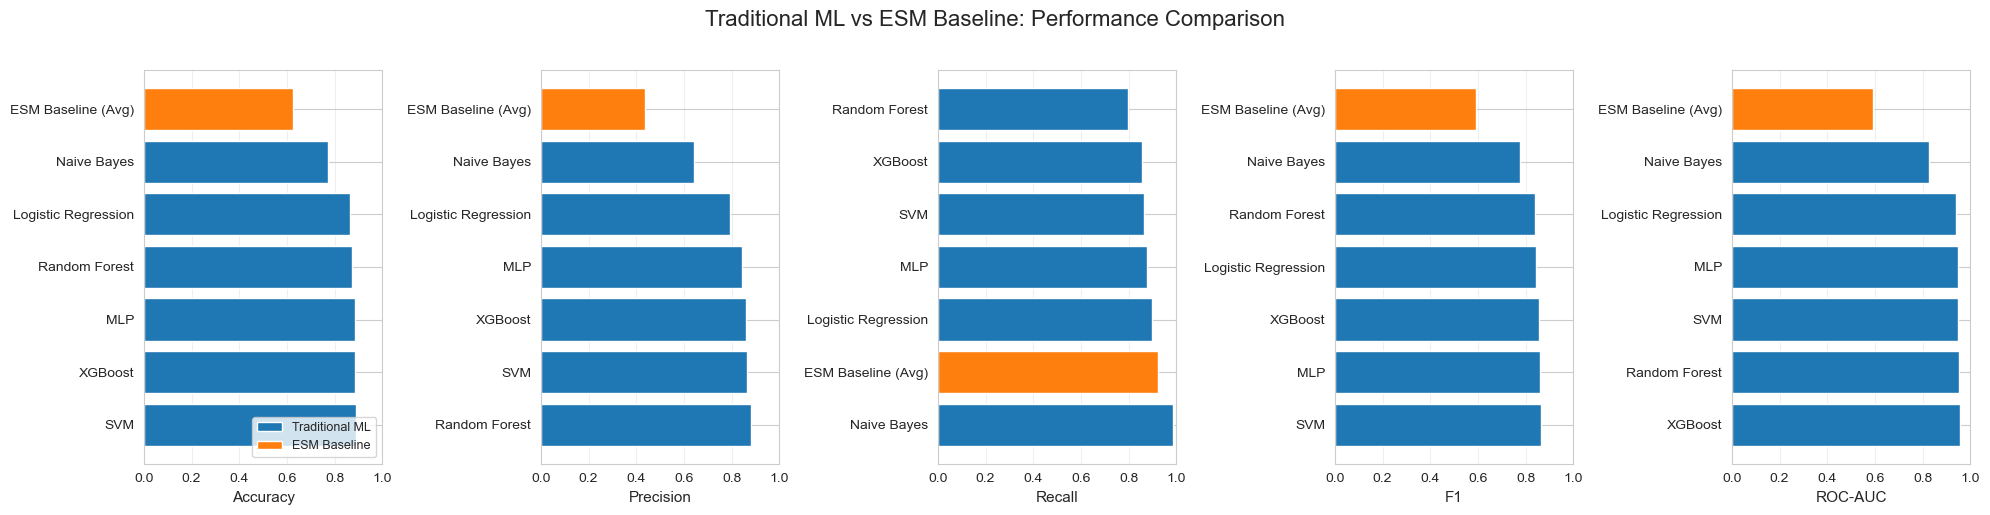


💾 Plot saved to 'graphs/ml_vs_esm_comparison.png'

📊 Summary:
   Best Traditional Model: SVM
      F1: 0.865, ROC-AUC: 0.949

   ESM Baseline (Average):
      F1: 0.592, ROC-AUC: 0.591

   ✅ Traditional ML outperforms ESM by 46.0% in F1


In [13]:
# Load ESM baseline results
esm_results = pd.read_csv("report 3 progress/graphs_results/model_results.csv", index_col=0)
print("ESM Baseline Results:\n")
display(esm_results)

# Get the average ESM performance
esm_avg = esm_results.loc['Average']

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results_df.index) + ['ESM Baseline (Avg)'],
    'Accuracy': list(results_df['Accuracy']) + [esm_avg['accuracy']],
    'Precision': list(results_df['Precision']) + [esm_avg['precision']],
    'Recall': list(results_df['Recall']) + [esm_avg['recall']],
    'F1': list(results_df['F1']) + [esm_avg['f1']],
    'ROC-AUC': list(results_df['ROC-AUC']) + [esm_avg['roc_auc']],
})

# Sort by F1
comparison_df = comparison_df.sort_values('F1', ascending=False).reset_index(drop=True)

print("Traditional ML vs ESM Baseline:\n")
display(comparison_df)

# Visualize comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 5))

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    # Sort by this metric
    metric_sorted = comparison_df.sort_values(metric, ascending=False)
    
    # Color ESM baseline differently
    colors = ['#1f77b4' if 'ESM' not in model else '#ff7f0e' for model in metric_sorted['Model']]
    
    bars = ax.barh(metric_sorted['Model'], metric_sorted[metric], color=colors)
    ax.set_xlabel(metric, fontsize=11)
    ax.set_xlim([0, 1.0])
    ax.grid(axis='x', alpha=0.3)
    
    # Highlight ESM baseline with different color in legend
    if i == 0:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#1f77b4', label='Traditional ML'),
            Patch(facecolor='#ff7f0e', label='ESM Baseline')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.suptitle('Traditional ML vs ESM Baseline: Performance Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('graphs/ml_vs_esm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Plot saved to 'graphs/ml_vs_esm_comparison.png'")

# Summary statistics
print("\n📊 Summary:")
best_traditional = results_df.iloc[0]
print(f"   Best Traditional Model: {results_df.index[0]}")
print(f"      F1: {best_traditional['F1']:.3f}, ROC-AUC: {best_traditional['ROC-AUC']:.3f}")
print(f"\n   ESM Baseline (Average):")
print(f"      F1: {esm_avg['f1']:.3f}, ROC-AUC: {esm_avg['roc_auc']:.3f}")

if best_traditional['F1'] > esm_avg['f1']:
    diff = ((best_traditional['F1'] - esm_avg['f1']) / esm_avg['f1']) * 100
    print(f"\n   ✅ Traditional ML outperforms ESM by {diff:.1f}% in F1")
else:
    diff = ((esm_avg['f1'] - best_traditional['F1']) / best_traditional['F1']) * 100
    print(f"\n   🤖 ESM outperforms best traditional ML by {diff:.1f}% in F1")


🔬 Detailed ESM Baseline Analysis:

ESM performance by distance metric:



,Distance Metric,F1 Score,ROC-AUC,Accuracy,Precision,Recall
0,Cosine Similarity,0.5849,0.6052,0.6210,0.4242,0.9416
1,Euclidean,0.5999,0.6643,0.6456,0.4533,0.8867
2,Manhattan,0.6084,0.6653,0.6458,0.4681,0.8689
3,Dot Product,0.5763,0.4298,0.5967,0.4049,0.9994
4,Average,0.5924,0.5911,0.6273,0.4376,0.9242


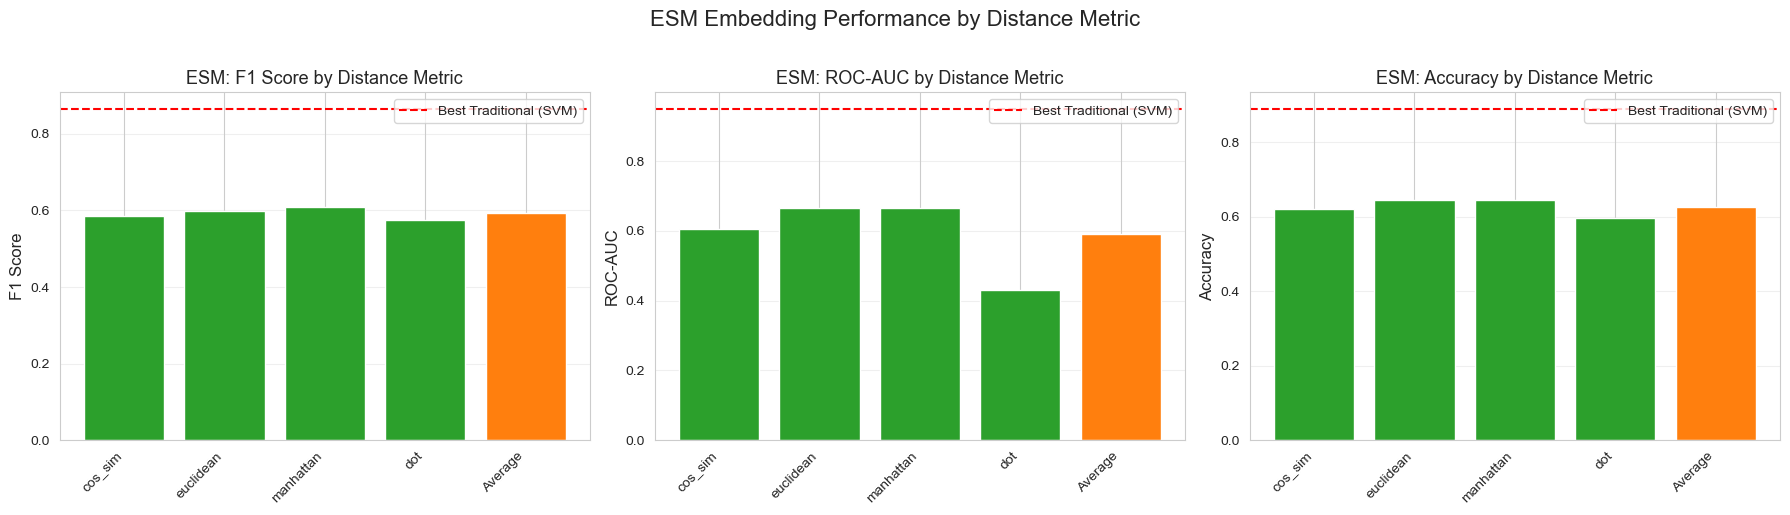


💾 Plot saved to 'graphs/esm_distance_metrics.png'

💡 Best ESM distance metric: manhattan (F1 = 0.608)


In [14]:
# Detailed comparison: Show all ESM distance metrics vs best traditional model
print("🔬 Detailed ESM Baseline Analysis:\n")
print("ESM performance by distance metric:\n")

# Create detailed comparison
detailed_comparison = pd.DataFrame({
    'Distance Metric': ['Cosine Similarity', 'Euclidean', 'Manhattan', 'Dot Product', 'Average'],
    'F1 Score': esm_results['f1'].values,
    'ROC-AUC': esm_results['roc_auc'].values,
    'Accuracy': esm_results['accuracy'].values,
    'Precision': esm_results['precision'].values,
    'Recall': esm_results['recall'].values,
})

display(detailed_comparison)

# Visualize ESM distance metrics performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score
ax = axes[0]
bars = ax.bar(range(len(esm_results)), esm_results['f1'], 
              color=['#2ca02c' if idx != len(esm_results)-1 else '#ff7f0e' 
                     for idx in range(len(esm_results))])
ax.set_xticks(range(len(esm_results)))
ax.set_xticklabels(esm_results.index, rotation=45, ha='right')
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('ESM: F1 Score by Distance Metric', fontsize=13)
ax.axhline(y=best_traditional['F1'], color='red', linestyle='--', label=f'Best Traditional ({results_df.index[0]})')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# ROC-AUC
ax = axes[1]
bars = ax.bar(range(len(esm_results)), esm_results['roc_auc'],
              color=['#2ca02c' if idx != len(esm_results)-1 else '#ff7f0e' 
                     for idx in range(len(esm_results))])
ax.set_xticks(range(len(esm_results)))
ax.set_xticklabels(esm_results.index, rotation=45, ha='right')
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('ESM: ROC-AUC by Distance Metric', fontsize=13)
ax.axhline(y=best_traditional['ROC-AUC'], color='red', linestyle='--', label=f'Best Traditional ({results_df.index[0]})')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Accuracy
ax = axes[2]
bars = ax.bar(range(len(esm_results)), esm_results['accuracy'],
              color=['#2ca02c' if idx != len(esm_results)-1 else '#ff7f0e' 
                     for idx in range(len(esm_results))])
ax.set_xticks(range(len(esm_results)))
ax.set_xticklabels(esm_results.index, rotation=45, ha='right')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('ESM: Accuracy by Distance Metric', fontsize=13)
ax.axhline(y=best_traditional['Accuracy'], color='red', linestyle='--', label=f'Best Traditional ({results_df.index[0]})')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.suptitle('ESM Embedding Performance by Distance Metric', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('graphs/esm_distance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Plot saved to 'graphs/esm_distance_metrics.png'")
print(f"\n💡 Best ESM distance metric: {esm_results['f1'].idxmax()} (F1 = {esm_results['f1'].max():.3f})")
